## 1. Load libraries and dataset

### 1.1. Load libraries

In [1]:
import numpy as np;
import pandas as pd;
# import datetime as dt;

import matplotlib.pyplot as plt;
import seaborn as sns;

from sklearn.model_selection import StratifiedKFold, cross_val_score;

from lightgbm import LGBMClassifier, LGBMRegressor;

import warnings;

pd.set_option('max_column', None);
warnings.filterwarnings('ignore');
sns.set_style('darkgrid');

### 1.2. Load dataset

In [2]:
# Load files
train = pd.read_csv('data/train.csv');
test = pd.read_csv('data/test.csv');
ss = pd.read_csv('data/SampleSubmission.csv');

In [3]:
# Peek at the train data
train.head(3)

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0


In [4]:
# Peek at the test set
test.head(3)

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0


In [5]:
# Let's see the shape of the train, test and metadata sets
print('The shape of the train set is:', train.shape, '\nThe shape of the test set is:', test.shape);

The shape of the train set is: (297177, 7) 
The shape of the test set is: (127361, 6)


### 1.3. Missing values and Combine train and test set for easy preprocessing 

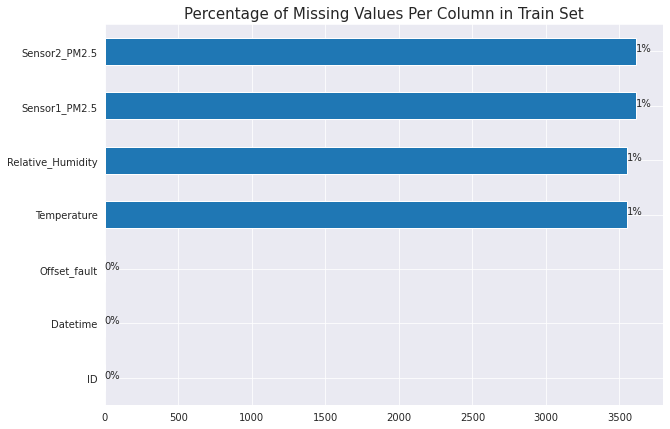

In [6]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

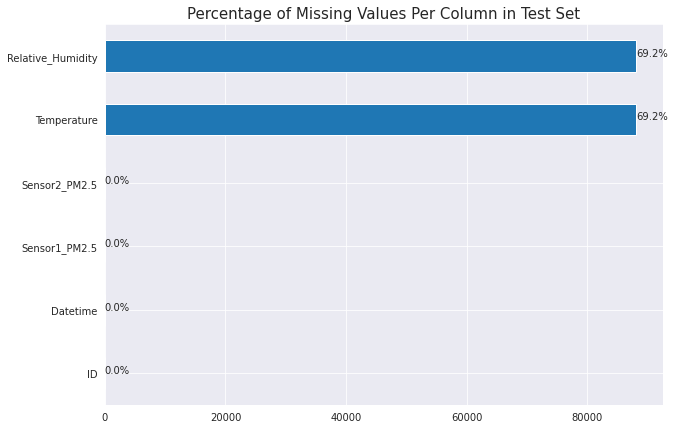

In [7]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [8]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print('The shape of the combined dataframe is:', all_data.shape)

The shape of the combined dataframe is: (424538, 7)


In [9]:
# Change each column to its appriopriate datatype
num_cols = ['Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature', 'Relative_Humidity'];
date_cols = ['Datetime'];

all_data['Datetime'] = pd.to_datetime(all_data['Datetime'], format='%Y-%m-%d %H:%M:%S');

In [10]:
# Let's extract day, month year and hour from the Datetime column
all_data['Year'] = all_data.Datetime.dt.year;
all_data['Month'] = all_data.Datetime.dt.month;
all_data['Hour'] = all_data.Datetime.dt.hour;
all_data['Quarter'] = all_data.Datetime.dt.quarter

In [11]:
# Sort according date
all_data.sort_values('Datetime', inplace=True, ignore_index=True);
all_data.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Year,Month,Hour,Quarter
0,ID_37STUCVVPZKP,2021-10-15 16:00:31,9.17,9.28,29.9,53.0,0.0,2021,10,16,4
1,ID_YZZUOMF0TQIF,2021-10-15 16:00:34,9.93,11.25,29.9,53.0,0.0,2021,10,16,4
2,ID_UF68QLIPG3LE,2021-10-15 16:01:01,6.53,3.15,29.9,53.0,1.0,2021,10,16,4
3,ID_KKCO4VATOSWB,2021-10-15 16:01:54,8.30,8.35,29.9,53.0,0.0,2021,10,16,4
4,ID_8YNKABZP11SS,2021-10-15 16:02:06,6.87,9.57,29.9,53.0,0.0,2021,10,16,4


In [12]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424538 entries, 0 to 424537
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 424538 non-null  object        
 1   Datetime           424538 non-null  datetime64[ns]
 2   Sensor1_PM2.5      420924 non-null  float64       
 3   Sensor2_PM2.5      420924 non-null  float64       
 4   Temperature        332899 non-null  float64       
 5   Relative_Humidity  332899 non-null  float64       
 6   Offset_fault       297177 non-null  float64       
 7   Year               424538 non-null  int64         
 8   Month              424538 non-null  int64         
 9   Hour               424538 non-null  int64         
 10  Quarter            424538 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(4), object(1)
memory usage: 35.6+ MB


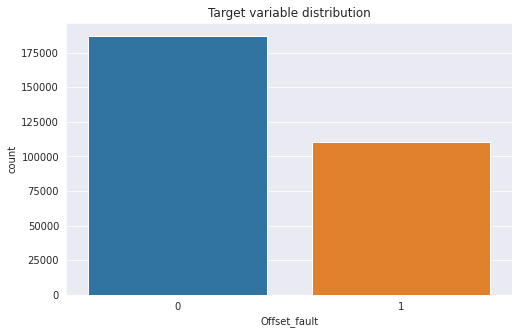

In [13]:
# Taret distribution
plt.figure(figsize=(8, 5));
sns.countplot(train["Offset_fault"]);
plt.title('Target variable distribution');
plt.show()

## 2. EDA

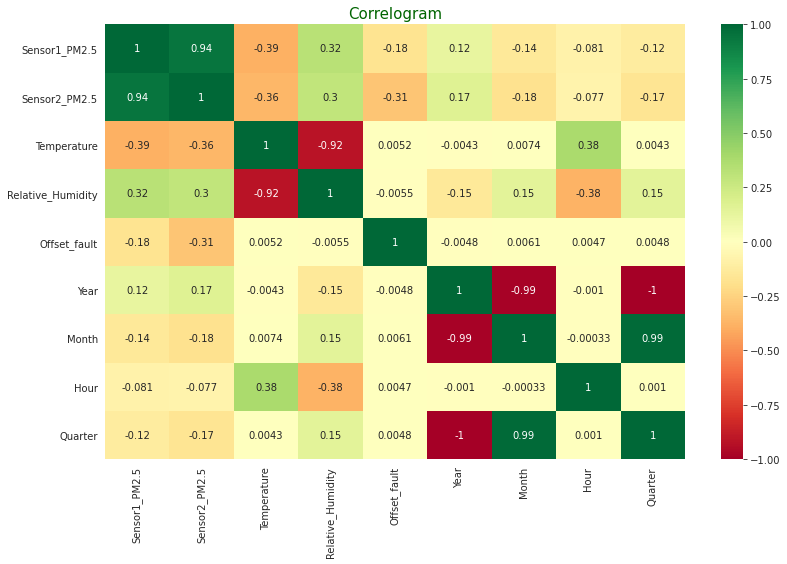

In [14]:
# Quantify correlations
corr = all_data.corr();
plt.figure(figsize = (13, 8));
sns.heatmap(corr, cmap='RdYlGn', annot=True, center=0);
plt.title('Correlogram', fontsize=15, color='darkgreen');
plt.show()

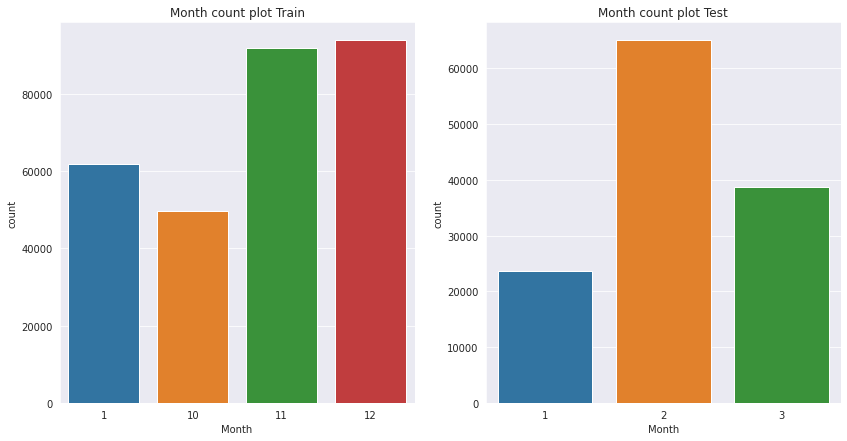

In [15]:
# Datetime month countplot
plt.figure(figsize = (14, 7));
plt.subplot(1, 2, 1);
sns.countplot(x='Month', data=all_data[~all_data.Offset_fault.isna()]);
plt.title('Month count plot Train');
plt.subplot(1, 2, 2);
sns.countplot(x='Month', data=all_data[all_data.Offset_fault.isna()]);
plt.title('Month count plot Test');

plt.show()

## 3. Preprocessing

### 3.1. Train : Fill nan value for 'Sensor1_PM2.5',  'Sensor2_PM2.5', 'Temperature' and 'Relative_Humidity'

In [16]:
def fill_nan(all_data, col):
    """ Fill nan value by averaging the previous and next value nan values in Train data """
    
    # Index of samples to fill
    idx_to_fill = all_data[~all_data.Offset_fault.isna()][all_data[col].isna()].index.values;
    for idx in idx_to_fill:
        all_data[col][idx] = (all_data[col][idx-1] + all_data[col][idx+1])/2;
    
    # Fill remaining nan values by the previous
    filled = all_data[~all_data.Offset_fault.isna()][col].fillna(method="ffill");
    all_data.loc[~all_data.Offset_fault.isna(), col] = filled;

In [17]:
# Fill nan values in 'Sensor1_PM2.5' and 'Sensor2_PM2.5'
fill_nan(all_data, 'Sensor1_PM2.5');
fill_nan(all_data, 'Sensor2_PM2.5');
fill_nan(all_data, 'Temperature');
fill_nan(all_data, 'Relative_Humidity');

### 3.2. Test : Fill nan values for  'Temperature', 'Relative_Humidity'

In [18]:
# Set datetime as index
all_data = all_data.set_index('Datetime',);

In [19]:
def plot_time_serie_2022(all_data, fill=False):
    ''' Plot data 2022 data '''
    
    # Split date into 2 : 2021 and 2022
    groups = all_data[['Temperature', 'Relative_Humidity']].groupby(pd.Grouper(freq='A'));

    # Get time series
    series_22 = groups.get_group(name='2022-12-31 00:00:00');
    
    # Plot times series for Temperature and Relative_Humidity  bottom=-0.9, 
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5));
    fig.subplots_adjust(hspace=0.6)
    
    for ax, data, name in zip(axes.flatten(), series_22, ['Temperature', 'Relative_Humidity']):
        ax.set_title('Time series for ' + name);
        series_22[name].plot(subplots=True, legend=False, ax=ax); 

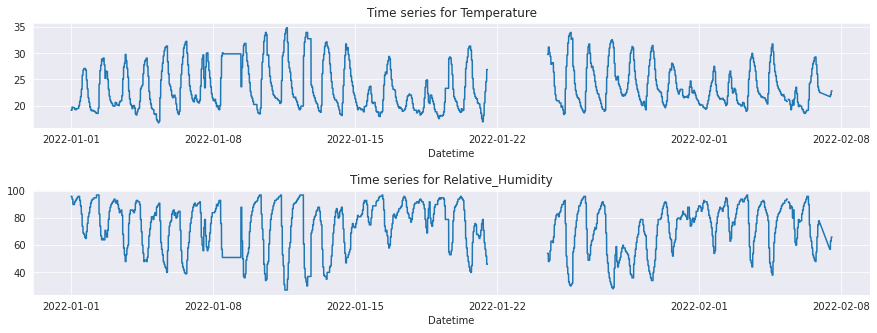

In [20]:
plot_time_serie_2022(all_data);

In [21]:
def fill_nanvalue(all_data, col):
    ''' Predict missing values '''
    
    all_data['Times'] = np.arange(0, all_data.shape[0]);
    
    if col == 'Temperature': #  and 'Relative_Humidity'
        data = all_data[['Times', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature']];
        X_train = data[~data.Temperature.isna()][['Times', 'Sensor1_PM2.5', 'Sensor2_PM2.5']];
        y_train = data[~data.Temperature.isna()][['Temperature']];
        X_test = data[data.Temperature.isna()][['Times', 'Sensor1_PM2.5', 'Sensor2_PM2.5']];
        
    elif col == 'Relative_Humidity':
        data = all_data[['Times', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature', 'Relative_Humidity']];
        X_train= data[~data.Relative_Humidity.isna()][['Times', 'Sensor1_PM2.5', 'Sensor2_PM2.5',
                                                       'Temperature']];
        y_train = data[~data.Relative_Humidity.isna()][['Relative_Humidity']];
        X_test = data[data.Relative_Humidity.isna()][['Times', 'Sensor1_PM2.5', 'Sensor2_PM2.5',
                                                      'Temperature']];
        
    # Fit model 
    model = LGBMRegressor();
    model = model.fit(X_train, y_train);
    
    # Forecast
    predictions = model.predict(X_test);
    
    # Fill nan values of col
    all_data.loc[all_data[col].isna(), col] = predictions;
    
    del all_data['Times'];    

In [22]:
# Let's fill missing valuee
fill_nanvalue(all_data, 'Temperature');
fill_nanvalue(all_data, 'Relative_Humidity');

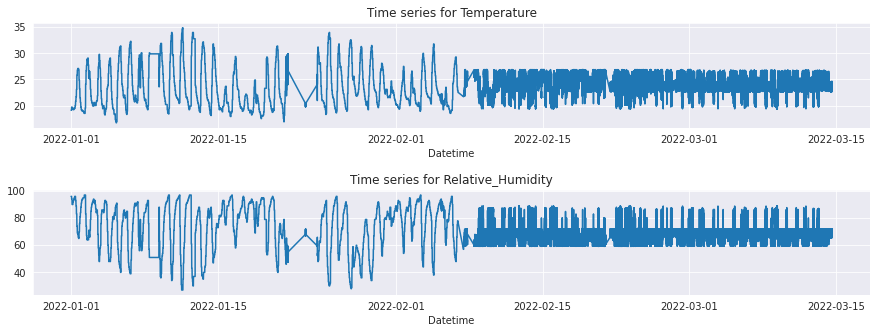

In [23]:
# Plot time series
plot_time_serie_2022(all_data);

### Reduce noise there is between 22-02-07 and 22-03-15

In [24]:
# Noise data
tmp = all_data[all_data.index > '2022-02-08'];

In [25]:
def smoothing(y, box_pts):
    ''' Use convolution to reduce the noise '''
    
    box = np.ones(box_pts)/box_pts;
    y_smooth = np.convolve(y, box, mode='same');
    return y_smooth;

In [26]:
def plot_reducing(temp_pts, hum_pts):
    
    plt.figure(1, figsize=(16, 5));
    plt.title('Smoothing');
    
    smooth = smoothing(tmp['Temperature'].values, temp_pts);
    plt.plot(tmp.index.values, smooth, label='Temperature');
    
    smooth = smoothing(tmp['Relative_Humidity'].values, hum_pts);
    plt.plot(tmp.index.values, smooth, label='Relative_Humidity');
    plt.legend();
    

In [27]:
def fix_noise(temp_pts, hum_pts):
    
    smooth = smoothing(tmp.Temperature, temp_pts);
    all_data.loc[all_data.index > '2022-02-08', 'Temperature'] = smooth;
    
    smooth = smoothing(tmp.Relative_Humidity, hum_pts);
    all_data.loc[all_data.index > '2022-02-08', 'Relative_Humidity'] = smooth;

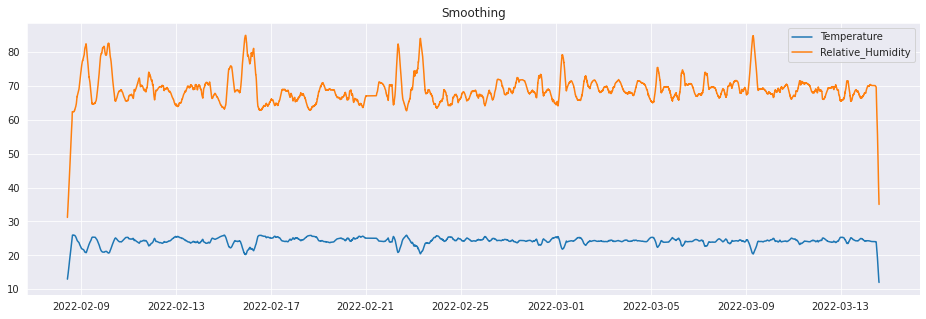

In [28]:
# Let's visualize reducing
plot_reducing(500, 500);

In [29]:
# Let's fix noise
fix_noise(500, 500);

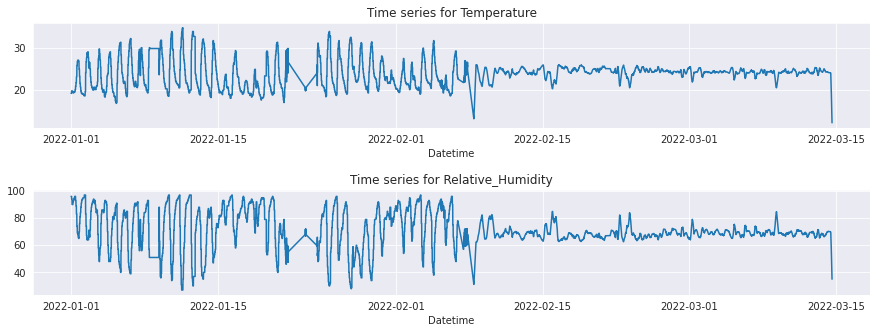

In [30]:
# Plot time series
plot_time_serie_2022(all_data);

## 3.3.  Extraction rolling mean

In [31]:
all_data['Rolling_1_25'] = all_data['Sensor1_PM2.5'].rolling(window=100).mean();
all_data['Rolling_2_25'] = all_data['Sensor2_PM2.5'].rolling(window=100).mean();
all_data['Rolling_Temp'] = all_data['Temperature'].rolling(window=200).mean();
all_data['Rolling_Hum'] = all_data['Relative_Humidity'].rolling(window=200).mean();

In [32]:
# Fill nan values
cols = ['Rolling_1_25', 'Rolling_2_25', "Rolling_Temp", "Rolling_Hum"];
all_data[cols] = all_data[cols].fillna(0);

## 4. Separate train and test data from the combined dataframe

In [33]:
# Separate train and test data from the combined dataframe
train_df = all_data[~all_data.Offset_fault.isna()];
test_df = all_data[all_data.Offset_fault.isna()];

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((297177, 14), (127361, 14))

In [34]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(['ID', 'Offset_fault']);

X = train_df[main_cols];
y = train_df.Offset_fault;

sfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=None);

In [36]:
# Evaluate LGB
scores = cross_val_score(LGBMClassifier(class_weight='balanced'), X, y, scoring='accuracy', cv=sfold);
print('%s : %.4f(%.4f)' % ('LGB', scores.mean(), scores.std()));

LGB : 0.9394(0.0263)


## 5. Fitting & Making predictions

In [37]:
# Fit & predict 
model = LGBMClassifier(class_weight='balanced');
model.fit(X, y);
predictions = model.predict(test_df[main_cols]);

In [38]:
# Tempory submission file
tmp= test_df[['ID']];
tmp['Offset_fault'] = predictions;

# Submission dataframe
ss = pd.merge(ss['ID'], tmp, how="left", on=["ID"]);
ss['Offset_fault'] = ss['Offset_fault'].astype(int);

0    87725
1    39636
Name: Offset_fault, dtype: int64


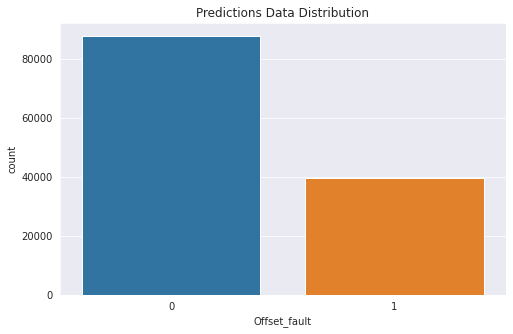

In [39]:
# Plot distribution of predictions
print(ss['Offset_fault'].value_counts());

plt.figure(figsize=(8, 5));
sns.countplot(ss.Offset_fault);
plt.title('Predictions Data Distribution');
plt.show()

In [40]:
# Create a csv file and upload to zindi 
ss.to_csv('sub.csv', index=False);

In [41]:
ss.head(10)

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,1
5,ID_N8BYOCJ2AOFM,1
6,ID_HF47YBS9WXCH,0
7,ID_S8EW0HOMWYRL,0
8,ID_OCBS3JVMM9CE,0
9,ID_U59U3D19H38F,1
